In [1]:
from pulp import *
import pandas as pd

In [2]:
cd C:\Users\cmgas\OneDrive\Documents\GradSchool\isye-6333

C:\Users\cmgas\OneDrive\Documents\GradSchool\isye-6333


In [3]:
time = pd.read_csv("./Supermarket Sweep.csv")
#set the start and end node to (0,0)
time.loc[len(time.index)] = ['End Node', 0.0, 0, 0]

## Part a. For each pair of items i, j in set [1,56], compute the shortest time to go from item i to item j as d[i][j]

In [4]:
#initialize the distance between each item
w, h = 58, 58
d = [[0 for x in range(w)] for y in range(h)] 

In [5]:
#calculate and store the shortest amount of time it will take to reach each item from every other item 
for i in range(0,58):
    for j in range (0,58):
        if time.iloc[i]['X Position'] == time.iloc[j]['X Position']:
            d[i][j] = abs(time.iloc[i]['Y Position'] - time.iloc[j]['Y Position'])/10
        else:
            d[i][j] = min(time.iloc[i]['Y Position'] + time.iloc[j]['Y Position'],220 - (time.iloc[i]['Y Position'] + time.iloc[j]['Y Position']))/10 + abs(time.iloc[i]['X Position'] - time.iloc[j]['X Position'])/10

## Part c. Code and solve the Supermarket Sweep optimization problem

In [6]:
#define v as the cost variable - value of each item
v = [0 for x in range(w)]
for i in range(0,58):
    v[i] = float(time.iloc[i]['Price'])

In [9]:
#define the problem
prob = LpProblem("Supermarketsweep", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
prob += z[57]

#ensuring each product is selected only once
for i in range(0,57):
    prob += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    prob += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    prob += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		prob += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
prob += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	prob += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	prob += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		prob += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
prob += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	prob += z[j] == lpSum([u[i][j] for i in range(0,57)])

for j in range(0,57):
	prob += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#total number of items picked should be less than 15 (need to include the starting point, so one more than 15)
prob += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#shopper must leave from the starting point
prob += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
prob += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
prob += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
prob += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	prob += x[i][i] == 0

#total time should be less than 90s
prob += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		prob += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		prob += u[i][j] >= 0

In [10]:
prob.solve(GUROBI_CMD())

1

In [11]:
print('Optimal Value: {}'.format(round(value(prob.objective),2)))

for i in range(0,58):
    for j in range(0,58):
        if value(x[i][j]) > 0.1:
            print('x_{}_{}: {}'.format(i,j,value(x[i][j])))

Optimal Value: 143.85
x_0_1: 1.0
x_1_2: 1.0
x_2_5: 1.0
x_5_25: 1.0
x_21_22: 1.0
x_22_57: 1.0
x_25_30: 1.0
x_26_27: 1.0
x_27_21: 1.0
x_30_35: 1.0
x_32_39: 1.0
x_33_32: 1.0
x_35_33: 1.0
x_38_40: 1.0
x_39_38: 1.0
x_40_26: 1.0


In [12]:
for i in range(0,58):
    if value(z[i]) > 0.1:
        print('z_{}: {}'.format(i,round(value(z[i]),2)))

z_1: 6.99
z_2: 17.98
z_5: 23.47
z_21: 117.86
z_22: 143.85
z_25: 32.46
z_26: 102.38
z_27: 112.37
z_30: 41.45
z_32: 75.42
z_33: 62.43
z_35: 48.44
z_38: 90.4
z_39: 83.41
z_40: 94.39
z_57: 143.85


In [13]:
for i in range(0,58):
    if value(y[i]) > 0.1:
        print('y_{}: {}'.format(i,value(y[i])))

y_1: 1.5
y_2: 3.5
y_5: 10.0
y_21: 51.0
y_22: 52.5
y_25: 16.0
y_26: 44.5
y_27: 45.5
y_30: 19.5
y_32: 31.0
y_33: 29.5
y_35: 25.5
y_38: 37.5
y_39: 37.0
y_40: 39.5
y_57: 60.0


In [14]:
Final_Solution = {'Selected Path (xij)': ['x_0_1', 'x_1_2', 'x_2_5', 'x_5_25', 'x_25_30', 'x_30_35', 'x_35_33', 'x_33_32', 'x_32_39', 'x_39_38', 'x_38_40', 'x_40_26', 'x_26_27', 'x_27_21', 'x_21_22', 'x_22_57'],
        'Items Selected': ['Coffee Beans', 'K-Cups', 'Granola', 'Tampons', 'Shampoo', 'Air Freshener', 'Broom', 'Detergent', 'Redbull', 'Gatorade', 'Ritz', 'Toilet Paper', 'Paper Towels', 'Ibuprofen', 'Diapers', 'End Node'],
        'Running Sum (zi)': [6.99, 17.98, 23.47, 32.46, 41.45, 48.44, 62.43, 75.42, 83.41, 90.40, 94.39, 102.38, 112.37, 117.86, 143.85, 143.85]}

print("An Optimal Solution for the Supermarket Sweep is:")
pd.DataFrame(Final_Solution)

An Optimal Solution for the Supermarket Sweep is:


,Selected Path (xij),Items Selected,Running Sum (zi)
0,x_0_1,Coffee Beans,6.99
1,x_1_2,K-Cups,17.98
2,x_2_5,Granola,23.47
3,x_5_25,Tampons,32.46
4,x_25_30,Shampoo,41.45
5,x_30_35,Air Freshener,48.44
6,x_35_33,Broom,62.43
7,x_33_32,Detergent,75.42
8,x_32_39,Redbull,83.41
9,x_39_38,Gatorade,90.40


## Part d. Test the effect of different time allotments on the optimal value
We will test six additional time allotments to evaluate how they change the objective value of the optimization problem: 60, 70, 80, 100, 110, and 120 seconds.

In [16]:
#60 seconds

#define the problem
prob2 = LpProblem("Supermarketsweep60", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
#t is 
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
#y is 
y = LpVariable.dicts("y", range(0,58), 0)
#u is
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
#z is the total value of items selected for the cart
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
prob2 += z[57]

#ensuring each product is selected only once
for i in range(0,57):
    prob2 += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    prob2 += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    prob2 += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		prob2 += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
prob2 += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	prob2 += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	prob2 += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		prob2 += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
prob2 += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	prob2 += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	prob2 += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#total number of items picked should be less than 15 (need to include the starting point, so one more than 15)
prob2 += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#shopper must leave from the starting point
prob2 += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
prob2 += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
prob2 += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
prob2 += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	prob2 += x[i][i] == 0

#total time should be less than 60s
prob2 += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 60

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		prob2 += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		prob2 += u[i][j] >= 0

In [18]:
prob2.solve(GUROBI_CMD())

1

In [19]:
print('Optimal Value: {}'.format(round(value(prob2.objective),2)))

Optimal Value: 101.7


In [20]:
#70 seconds

#define the problem
prob3 = LpProblem("Supermarketsweep70", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
prob3 += z[57]

#ensuring each product is selected only once
for i in range(0,57):
    prob3 += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    prob3 += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    prob3 += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		prob3 += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
prob3 += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	prob3 += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	prob3 += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		prob3 += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
prob3 += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	prob3 += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	prob3 += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#total number of items picked should be less than 15 (need to include the starting point, so one more than 15)
prob3 += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#shopper must leave from the starting point
prob3 += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
prob3 += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
prob3 += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
prob3 += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	prob3 += x[i][i] == 0

#total time should be less than or equal to 70s
prob3 += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 70

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		prob3 += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		prob3 += u[i][j] >= 0

In [21]:
prob3.solve(GUROBI_CMD())

1

In [22]:
print('Optimal Value: {}'.format(round(value(prob3.objective),2)))

Optimal Value: 119.68


In [25]:
#80 seconds

#define the problem
prob4 = LpProblem("Supermarketsweep80", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
prob4 += z[57]

#ensuring each product is selected only once
for i in range(0,57):
    prob4 += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    prob4 += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    prob4 += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		prob4 += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
prob4 += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	prob4 += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	prob4 += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		prob4 += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
prob4 += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	prob4 += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	prob4 += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#total number of items picked should be less than 15 (need to include the starting point, so one more than 15)
prob4 += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#shopper must leave from the starting point
prob4 += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
prob4 += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
prob4 += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
prob4 += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	prob4 += x[i][i] == 0

#total time should be less than 80s
prob4 += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 80

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		prob4 += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		prob4 += u[i][j] >= 0

In [26]:
prob4.solve(GUROBI_CMD())

1

In [27]:
print('Optimal Value: {}'.format(round(value(prob4.objective),2)))

Optimal Value: 135.65


In [30]:
#100 seconds

#define the problem
prob5 = LpProblem("Supermarketsweep100", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
prob5 += z[57]

#ensuring each product is selected only once
for i in range(0,57):
    prob5 += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    prob5 += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    prob5 += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		prob5 += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
prob5 += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	prob5 += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	prob5 += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		prob5 += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
prob5 += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	prob5 += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	prob5 += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#total number of items picked should be less than 15 (need to include the starting point, so one more than 15)
prob5 += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#shopper must leave from the starting point
prob5 += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
prob5 += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
prob5 += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
prob5 += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	prob5 += x[i][i] == 0

#total time should be less than 100s
prob5 += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 100

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		prob5 += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		prob5 += u[i][j] >= 0

In [31]:
prob5.solve(GUROBI_CMD())

1

In [32]:
print('Optimal Value: {}'.format(round(value(prob5.objective),2)))

Optimal Value: 151.65


In [34]:
#110 seconds

#define the problem
prob6 = LpProblem("Supermarketsweep110", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
prob6 += z[57]

#ensuring each product is selected only once
for i in range(0,57):
    prob6 += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    prob6 += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    prob6 += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		prob6 += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
prob6 += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	prob6 += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	prob6 += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		prob6 += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
prob6 += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	prob6 += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	prob6 += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#total number of items picked should be less than 15 (need to include the starting point, so one more than 15)
prob6 += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#shopper must leave from the starting point
prob6 += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
prob6 += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
prob6 += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
prob6 += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	prob6 += x[i][i] == 0

#total time should be less than 110s
prob6 += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 110

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		prob6 += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		prob6 += u[i][j] >= 0

In [35]:
prob6.solve(GUROBI_CMD())

1

In [36]:
print('Optimal Value: {}'.format(round(value(prob6.objective),2)))

Optimal Value: 154.85


In [8]:
#120 seconds

#define the problem
prob7 = LpProblem("Supermarketsweep120", LpMaximize)

x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
prob7 += z[57]

#ensuring each product is selected only once
for i in range(0,57):
    prob7 += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    prob7 += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    prob7 += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		prob7 += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
prob7 += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	prob7 += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	prob7 += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		prob7 += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
prob7 += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	prob7 += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	prob7 += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#total number of items picked should be less than 15 (need to include the starting point, so one more than 15)
prob7 += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#shopper must leave from the starting point
prob7 += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
prob7 += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
prob7 += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
prob7 += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	prob7 += x[i][i] == 0

#total time should be less than 120s
prob7 += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 120

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		prob7 += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		prob7 += u[i][j] >= 0

In [9]:
prob7.solve(GUROBI_CMD())

1

In [10]:
print('Optimal Value: {}'.format(round(value(prob7.objective),2)))

Optimal Value: 154.85


In [11]:
#130 seconds

#define the problem
prob8 = LpProblem("Supermarketsweep130", LpMaximize)

x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
prob8 += z[57]

#ensuring each product is selected only once
for i in range(0,57):
    prob8 += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    prob8 += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    prob8 += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		prob8 += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
prob8 += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	prob8 += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	prob8 += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		prob8 += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
prob8 += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	prob8 += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	prob8 += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#total number of items picked should be less than 15 (need to include the starting point, so one more than 15)
prob8 += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#shopper must leave from the starting point
prob8 += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
prob8 += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
prob8 += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
prob8 += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	prob8 += x[i][i] == 0

#total time should be less than 130s
prob8 += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 130

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		prob8 += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		prob8 += u[i][j] >= 0

In [12]:
prob8.solve(GUROBI_CMD())

1

In [13]:
print('Optimal Value: {}'.format(round(value(prob8.objective),2)))

Optimal Value: 154.85


In [37]:
#store the values 
x = [60, 70, 80, 90, 100, 110, 120, 130]
y = [101.7, 119.68, 135.65, 143.85, 151.65, 154.85, 154.85, 154.85]

In [15]:
import matplotlib.pyplot as plt

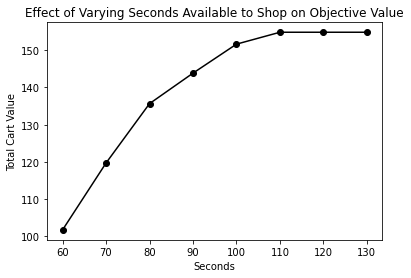

In [39]:
plt.plot(x, y, '-ok')
plt.xlabel("Seconds")
plt.ylabel("Total Cart Value")
plt.title("Effect of Varying Seconds Available to Shop on Objective Value");

## Part e. Test the effect of different cart capacities on the optimal value
We will test ten additional cart capacities: 10, 11, 12, 13, 14, 16, 17, 18, 19, and 20 items.

In [37]:
#10 items

#define the problem
proba = LpProblem("Supermarketsweep10", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
proba += z[57]

#total number of items picked should be less than or equal to 10
proba += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 11

#ensuring each product is selected only once
for i in range(0,57):
    proba += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    proba += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    proba += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		proba += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
proba += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	proba += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	proba += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		proba += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
proba += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	proba += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	proba += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
proba += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
proba += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
proba += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
proba += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	proba += x[i][i] == 0

#total time should be less than 90s
proba += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		proba += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		proba += u[i][j] >= 0

In [38]:
proba.solve(GUROBI_CMD())

1

In [39]:
print('Optimal Value: {}'.format(round(value(proba.objective),2)))

Optimal Value: 118.9


In [40]:
#11 items

#define the problem
probb = LpProblem("Supermarketsweep11", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probb += z[57]

#total number of items picked should be less than or equal to 11
probb += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 12

#ensuring each product is selected only once
for i in range(0,57):
    probb += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probb += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probb += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probb += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probb += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probb += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probb += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probb += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probb += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probb += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probb += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probb += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probb += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probb += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probb += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probb += x[i][i] == 0

#total time should be less than 90s
probb += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probb += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probb += u[i][j] >= 0

In [41]:
probb.solve(GUROBI_CMD())

1

In [42]:
print('Optimal Value: {}'.format(round(value(probb.objective),2)))

Optimal Value: 125.89


In [44]:
#12 items

#define the problem
probc = LpProblem("Supermarketsweep12", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probc += z[57]

#total number of items picked should be less than or equal to 12
probc += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 13

#ensuring each product is selected only once
for i in range(0,57):
    probc += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probc += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probc += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probc += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probc += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probc += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probc += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probc += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probc += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probc += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probc += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probc += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probc += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probc += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probc += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probc += x[i][i] == 0

#total time should be less than 90s
probc += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probc += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probc += u[i][j] >= 0

In [45]:
probc.solve(GUROBI_CMD())

1

In [46]:
print('Optimal Value: {}'.format(round(value(probc.objective),2)))

Optimal Value: 132.88


In [47]:
#13 items

#define the problem
probd = LpProblem("Supermarketsweep13", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probd += z[57]

#total number of items picked should be less than or equal to 13
probd += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 14

#ensuring each product is selected only once
for i in range(0,57):
    probd += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probd += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probd += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probd += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probd += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probd += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probd += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probd += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probd += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probd += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probd += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probd += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probd += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probd += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probd += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probd += x[i][i] == 0

#total time should be less than 90s
probd += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probd += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probd += u[i][j] >= 0

In [48]:
probd.solve(GUROBI_CMD())

1

In [49]:
print('Optimal Value: {}'.format(round(value(probd.objective),2)))

Optimal Value: 138.37


In [50]:
#14 items

#define the problem
probe = LpProblem("Supermarketsweep14", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probe += z[57]

#total number of items picked should be less than or equal to 14
probe += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 15

#ensuring each product is selected only once
for i in range(0,57):
    probe += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probe += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probe += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probe += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probe += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probe += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probe += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probe += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probe += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probe += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probe += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probe += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probe += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probe += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probe += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probe += x[i][i] == 0

#total time should be less than 90s
probe += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probe += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probe += u[i][j] >= 0

In [51]:
probe.solve(GUROBI_CMD())

1

In [53]:
print('Optimal Value: {}'.format(round(value(probe.objective),2)))

Optimal Value: 140.06


In [54]:
#16 items

#define the problem
probf = LpProblem("Supermarketsweep16", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probf += z[57]

#total number of items picked should be less than or equal to 16
probf += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 17

#ensuring each product is selected only once
for i in range(0,57):
    probf += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probf += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probf += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probf += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probf += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probf += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probf += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probf += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probf += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probf += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probf += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probf += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probf += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probf += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probf += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probf += x[i][i] == 0

#total time should be less than 90s
probf += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probf += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probf += u[i][j] >= 0

In [55]:
probf.solve(GUROBI_CMD())

1

In [64]:
print('Optimal Value: {}'.format(round(value(probf.objective),2)))

Optimal Value: 147.64


In [17]:
#17 items

#define the problem
probg = LpProblem("Supermarketsweep17", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probg += z[57]

#total number of items picked should be less than or equal to 17
probg += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 18

#ensuring each product is selected only once
for i in range(0,57):
    probg += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probg += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probg += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probg += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probg += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probg += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probg += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probg += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probg += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probg += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probg += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probg += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probg += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probg += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probg += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probg += x[i][i] == 0

#total time should be less than 90s
probg += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probg += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probg += u[i][j] >= 0

In [18]:
probg.solve(GUROBI_CMD())

1

In [19]:
print('Optimal Value: {}'.format(round(value(probg.objective),2)))

Optimal Value: 147.83


In [20]:
#18 items

#define the problem
probh = LpProblem("Supermarketsweep18", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probh += z[57]

#total number of items picked should be less than or equal to 18
probh += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 19

#ensuring each product is selected only once
for i in range(0,57):
    probh += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probh += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probh += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probh += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probh += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probh += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probh += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probh += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probh += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probh += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probh += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probh += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probh += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probh += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probh += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probh += x[i][i] == 0

#total time should be less than 90s
probh += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probh += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probh += u[i][j] >= 0

In [21]:
probh.solve(GUROBI_CMD())

1

In [22]:
print('Optimal Value: {}'.format(round(value(probh.objective),2)))

Optimal Value: 148.82


In [23]:
#19 items

#define the problem
probi = LpProblem("Supermarketsweep19", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probi += z[57]

#total number of items picked should be less than or equal to 19
probi += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 20

#ensuring each product is selected only once
for i in range(0,57):
    probi += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probi += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probi += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probi += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probi += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probi += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probi += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probi += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probi += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probi += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probi += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probi += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probi += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probi += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probi += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probi += x[i][i] == 0

#total time should be less than 90s
probi += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probi += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probi += u[i][j] >= 0

In [24]:
probi.solve(GUROBI_CMD())

1

In [25]:
print('Optimal Value: {}'.format(round(value(probi.objective),2)))

Optimal Value: 148.82


In [26]:
#20 items

#define the problem
probj = LpProblem("Supermarketsweep20", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probj += z[57]

#total number of items picked should be less than or equal to 20
probj += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 21

#ensuring each product is selected only once
for i in range(0,57):
    probj += lpSum([x[i][j] for j in range(1,58)]) <= 1

#ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probj += lpSum([x[i][j] for i in range(0,57)]) <= 1

#ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probj += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probj += t[i][j] <= 100000*x[i][j]

#initial time is = to 0
probj += y[0] == 0

#the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probj += y[j] == lpSum([t[i][j] for i in range(0,57)])

for j in range(0,57):
	probj += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probj += u[i][j] <= 100000*x[i][j]

#initial value of items picked = 0
probj += z[0] == 0

#the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probj += z[j] == lpSum([u[i][j] for i in range(0,57)])

#same as above
for j in range(0,57):
	probj += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#shopper must leave from the starting point
probj += lpSum([x[0][j] for j in range(1,58)]) == 1

#shopper must end at the starting point
probj += lpSum([x[i][57] for i in range(0,57)]) == 1

#shopper should not go to starting point any time during the sweep
probj += lpSum([x[i][0] for i in range(1,58)]) == 0

#shopper should not go to the end point any time during the sweep
probj += lpSum([x[57][j] for j in range(0,57)]) == 0

#shopper should not go to the same item twice
for i in range(0,58):
	probj += x[i][i] == 0

#total time should be less than 90s
probj += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probj += t[i][j] >= 0

for i in range(0,58):
	for j in range(0,58):
		probj += u[i][j] >= 0

In [27]:
probj.solve(GUROBI_CMD())

1

In [28]:
print('Optimal Value: {}'.format(round(value(probj.objective),2)))

Optimal Value: 148.82


In [30]:
#store the values
x1 = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]
y1 = [118.9, 125.89, 132.88, 138.37, 140.06, 143.85, 147.64, 147.83, 148.82, 148.82, 148.82]

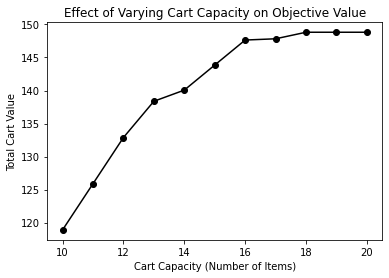

In [33]:
#chart our results
plt.plot(x1, y1, '-ok')
plt.xlabel("Cart Capacity (Number of Items)")
plt.ylabel("Total Cart Value")
plt.title("Effect of Varying Cart Capacity on Objective Value");

## Part f. Effect of Varying MIPGap on Objective Value
We will try five other values of MIPGap: a baseline of .0001, then a loosening of the constraint to .001, .01, .1, and 1.

In [7]:
#MIPGap of .0001 : baseline

#define the problem
probz = LpProblem("SupermarketsweepBaseline", LpMaximize)
x = LpVariable.dicts("x", (range(0,58), range(0,58)), 0, cat='Binary')
t = LpVariable.dicts("t", (range(0,58), range(0,58)), 0)
y = LpVariable.dicts("y", range(0,58), 0)
u = LpVariable.dicts("u", (range(0,58), range(0,58)), 0)
z = LpVariable.dicts("z", range(0,58), 0)

#objective function: maximize the value of all items selected for the cart
probz += z[57]

#total number of items picked should be less than or equal to 15
probz += lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) <= 16

#1 ensuring each product is selected only once
for i in range(0,57):
    probz += lpSum([x[i][j] for j in range(1,58)]) <= 1

#2 ensuring the shopper arrives at each item a maximum of one time
for j in range(1,58):
    probz += lpSum([x[i][j] for i in range(0,57)]) <= 1

#3 ensuring if the shopper arrives at an item, they will leave it exactly once
for j in range(1,57):
    probz += lpSum([x[i][j] for i in range(0,57)]) == lpSum([x[j][i] for i in range(1,58)])

#4 connect t and x variables
for i in range(0,58):
	for j in range(0,58):
		probz += t[i][j] <= 100000*x[i][j]

#5 initial time is = to 0
probz += y[0] == 0

#6 the next two constraints calculate the running sum of total time required to move to all selected items 
for j in range(1,58):
	probz += y[j] == lpSum([t[i][j] for i in range(0,57)])

#7
for j in range(0,57):
	probz += lpSum([t[j][k] for k in range(1,58)]) == y[j] + lpSum([d[j][k]*x[j][k] for k in range(1,58)])

#8 connecting x and u variables
for i in range(0,58):
	for j in range(0,58):
		probz += u[i][j] <= 100000*x[i][j]

#9 initial value of items picked = 0
probz += z[0] == 0

#10 the next two constraints calculate running sum of value of items picked for the cart
for j in range(1,58):
	probz += z[j] == lpSum([u[i][j] for i in range(0,57)])

#11 same as above
for j in range(0,57):
	probz += lpSum([u[j][k] for k in range(1,58)]) == z[j] + lpSum([v[k]*x[j][k] for k in range(1,58)])

#12 shopper must leave from the starting point
probz += lpSum([x[0][j] for j in range(1,58)]) == 1

#13 shopper must end at the starting point
probz += lpSum([x[i][57] for i in range(0,57)]) == 1

#14 shopper should not go to starting point any time during the sweep
probz += lpSum([x[i][0] for i in range(1,58)]) == 0

#15 shopper should not go to the end point any time during the sweep
probz += lpSum([x[57][j] for j in range(0,57)]) == 0

#16 shopper should not go to the same item twice
for i in range(0,58):
	probz += x[i][i] == 0

#17 total time should be less than 90s
probz += y[57] + (lpSum([x[i][j] for j in range(1,58) for i in range(0,57)]) - 1)*2 <= 90

#18 non-negativity constraints
for i in range(0,58):
	for j in range(0,58):
		probz += t[i][j] >= 0

#19 for i in range(0,58):
	for j in range(0,58):
		probz += u[i][j] >= 0

In [ ]:
import time
start_time = time.time()
probz.solve(GUROBI_CMD())
print("My program took", time.time() - start_time, "to run")

In [15]:
print('Optimal Value: {}'.format(round(value(probz.objective),2)))

NameError: name 'probz' is not defined

In [43]:
#test with an MIPGap of .001
start_time = time.time()
probz.solve(GUROBI_CMD(options=[("MIPgap", 0.001)]))
print("The program took", time.time() - start_time, "s to run")

The program took 688.9181971549988 s to run


In [ ]:
print('Optimal Value: {}'.format(round(value(probz.objective),2)))

In [ ]:
#test with an MIPGap of .01
import time
start_time = time.time()
probz.solve(GUROBI_CMD(options=[("MIPgap", 0.01)]))
print("The program took", time.time() - start_time, "s to run")

In [ ]:
print('Optimal Value: {}'.format(round(value(probz.objective),2)))

In [12]:
#test with an MIPGap of .1
start_time = time.time()
probz.solve(GUROBI_CMD(options=[("MIPgap", 0.1)]))
print("The program took", time.time() - start_time, "s to run")

The program took 9.508492946624756 s to run


In [13]:
print('Optimal Value: {}'.format(round(value(probz.objective),2)))

Optimal Value: 139.86


In [10]:
#test with an MIPGap of 1
import time
start_time = time.time()
probz.solve(GUROBI_CMD(options=[("MIPgap", 1)]))
print("The program took", time.time() - start_time, "s to run")

The program took 5.924500942230225 s to run


In [11]:
print('Optimal Value: {}'.format(round(value(probz.objective),2)))

Optimal Value: 129.88


In [47]:
#store values for part f
x2 = [.0001, .001, .01, .1, 1]
y2 = [765.81, 688.92, 519.44, 4.55, 1.36]

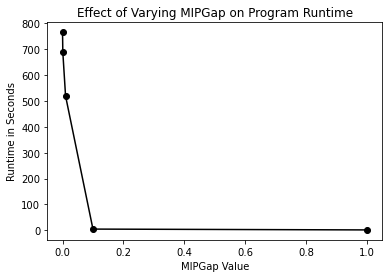

In [48]:
#plot the results
plt.plot(x2, y2, '-ok')
plt.xlabel("MIPGap Value")
plt.ylabel("Runtime in Seconds")
plt.title("Effect of Varying MIPGap on Program Runtime");